# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcCorr_NLP.ipynb
This script compares the NLP time series of media flood reports against the precip and inundation data, at monthly time series. I perform a field correlation (i.e. time series of media reports versus spatiotemporal data of precip and inundation.)

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [3]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the NLP data on the count of media reports

In [222]:
nlp=pd.read_csv('C:/Users/alexsaunders/Documents/01_uoa/04_git/dissertation/data/nlp/processed/ArticlesByDayByDivision.csv', index_col=0)#, keep_default_na=False)
nlp.index = pd.to_datetime(nlp.index)
nlp=nlp.iloc[:, :-5]
# nlp[nlp=='']=np.nan

### Create xarray and resample to monthly

In [223]:
divs=list(nlp.columns.str.capitalize())
times=list(nlp.index)

In [224]:
# Convert to xarray data array
nlpxr = xr.DataArray(
    nlp,
    coords={'time': times, 'division': divs},
    dims=['time', 'division']
)

In [70]:
# Set nans to zero since we want to use all data - maybe not the best assumption?
# nlpxr = nlpxr.fillna(0)

In [225]:
nlpMonthlyCount = nlpxr.resample(time='1M', skipna=True).sum(dim='time')

## 2) Load the precip and FIA data

In [92]:
chirpsPath=rootPath/'chirps'
rawPath=chirpsPath/'raw'
precip = xr.open_dataarray(chirpsPath/'xr/precip.nc')
precip

<xarray.DataArray (time: 1584, lat: 120, lon: 93)>
[17677440 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-06 ... 2022-12-26
  * lat      (lat) float64 26.62 26.57 26.52 26.47 ... 20.82 20.77 20.72 20.67
  * lon      (lon) float64 88.03 88.08 88.13 88.18 ... 92.48 92.53 92.58 92.63

In [93]:
FIAPath = rootPath/'pixelFIA/xr/'
FIA = xr.open_dataarray(FIAPath/'pixelFIA.nc')
FIA = FIA.where(FIA!=-9999, np.nan)
FIA

<xarray.DataArray (lat: 1346, lon: 1040, time: 985)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 26.63 26.63 26.62 26.62 ... 20.61 20.6 20.6 20.59
  * lon      (lon) float64 88.01 88.01 88.02 88.02 ... 92.66 92.67 92.67 92.68
  * time     (time) datetime64[ns] 2001-06-13 2001-06-29 ... 2022-12-30

## 3) Resample precip and FIA to monthly max

In [94]:
precipMonthlyMax = precip.resample(time='1M', skipna=True).max(dim='time')

In [95]:
FIAMonthlyMax = FIA.resample(time='1M', skipna=True).max(dim='time')

In [96]:
# Change time to first dimension
FIAMonthlyMax=FIAMonthlyMax.transpose("time", "lat", "lon")

### Downsample FIA to lower resolution

In [135]:
resFactor=11
FIAMonthlyMaxCoarse = FIAMonthlyMax.coarsen(lat=resFactor, boundary='trim').mean(skipna=True).coarsen(lon=resFactor, boundary='trim').mean(skipna=True)

In [136]:
np.nanmin(FIAMonthlyMaxCoarse), np.nanmax(FIAMonthlyMaxCoarse)

(0.006095471807316808, 0.9980024248361588)

In [133]:
np.nanmin(FIAMonthlyMaxCoarse), np.nanmax(FIAMonthlyMaxCoarse)

(0.006095471807316808, 0.9980024248361588)

### Subset to overlapping time period (drop a few months in one dataset)

In [113]:
precipMonthlyMax=precipMonthlyMax[precipMonthlyMax.time.isin(FIAMonthlyMaxCoarse.time)]

### Sum over whole country at each timestep

In [119]:
precipMonthlyTotal=precipMonthlyMax.sum(dim=["lat", "lon"])
FIAMonthlyTotal=FIAMonthlyMaxCoarse.mean(dim=["lat", "lon"]) # Mean because is a fraction, multiple by country area for total inundation area

Might be not quite right for FIA, need to take mean of raw values at weekly timesteps, and then take the monthly max...

In [138]:
FIACoarse=FIA.coarsen(lat=resFactor, boundary='trim').mean(skipna=True).coarsen(lon=resFactor, boundary='trim').mean(skipna=True)
FIACoarseWeeklyTotal=FIACoarse.mean(dim=["lat", "lon"])
FIAMonthlyTotal2=FIACoarseWeeklyTotal.resample(time='1M', skipna=True).max(dim='time')

In [134]:
np.nanmin(FIACoarse), np.nanmax(FIACoarse)

(0.0016781108466804855, 0.9980024248361588)

Does produce slight differences, use the second logic seems more correct!

In [143]:
FIAMonthlyTotal=FIAMonthlyTotal2

Do the same for precip

In [167]:
precipWeeklyTotal=precip.sum(dim=["lat", "lon"])
precipMonthlyTotal2=precipWeeklyTotal.resample(time='1M', skipna=True).max(dim='time')

In [158]:
precipMonthlyTotal2=precipMonthlyTotal2[precipMonthlyTotal2.time.isin(FIAMonthlyMaxCoarse.time)]

In [159]:
precipMonthlyTotal

<xarray.DataArray (time: 259)>
array([1295568.50189972, 1369096.96551514, 1045151.69118118,
       1318991.4581337 , 1257070.38013458,  164014.89233994,
         12890.27825311,   31196.85119364,   22935.85689652,
        251427.41656494,  603549.74970055,  950722.180686  ,
       1342941.69855118, 1624828.97795868, 1192761.65544128,
       1120775.66342735,  431940.72818947,  332950.60994703,
         11496.88153467,   26024.6614213 ,   56747.3469691 ,
        274219.85349703,  411097.75209713,  730090.94324017,
       1861939.24454117, 1229934.22499847,  829273.88628578,
        880335.2292366 , 1248252.52653885,   22112.01626283,
         25373.12917036,   24208.66897613,   15206.57418725,
         92620.40707344,  998153.31706619,  929390.5527668 ,
       1828364.61081314, 1588162.93338394, 1021268.08831787,
       1583030.41126633, 1284623.83669281,   17413.75624019,
         10154.19961363,   44199.32306644,   44255.63487172,
        367231.61202002,  451101.33214998,  822033.11542988,
       1028061.89422607, 1526099.06368637, 1316602.27355194,
        825449.43044472, 1428641.99952698,   27713.88604981,
          8948.70800728,   11211.40554336,   36747.66988218,
         64991.45569646,  551244.64559364, 1348378.79205894,
...
        249661.90200138,  544836.69287968,  941071.9319458 ,
       1305221.58502769, 1505464.82122803,  786682.25392342,
        776756.55611992,  448186.83825946,   35489.3533659 ,
         22231.72558469,   12137.74564016,  136599.62698847,
        246727.44764066,  600794.12073302, 1027128.9817009 ,
       1163334.00940704, 1991127.71355438, 1055600.18815041,
        942233.62018204,  599507.16477108,  394023.99363399,
         16520.48869498,  131138.0218941 ,   32922.10303026,
        115698.94056588,  621049.81987   , 1000564.23902321,
       1274185.9765625 , 1296236.13826752,  990482.40631866,
       1304727.49853134, 1056123.54777908,  130852.47163892,
          9716.03323945,   12350.09965107,   16052.60214701,
        119304.59585172,  210186.08989501,  767363.56788826,
       1297494.58185196, 1410781.9583168 , 1169824.06855965,
        869897.72788811, 1064736.91284943,   24519.06636298,
        128116.01445246,   40984.98058984,  124416.55245751,
         85306.23491281,  297670.63150692, 1006098.55921555,
       1455344.56208038,  999132.71211815,  836061.68881226,
       1080828.49249458, 1127288.86351013,   15342.1963374 ,
         15822.97368672])
Coordinates:
  * time     (time) datetime64[ns] 2001-06-30 2001-07-31 ... 2022-12-31

In [160]:
precipMonthlyTotal2

<xarray.DataArray (time: 259)>
array([1215598.27281189, 1211538.53238487,  803673.08392429,
       1096439.97801399, 1122626.69620323,  149789.72728893,
         11616.29835974,   30310.88113695,   20976.14211024,
        249604.62001312,  510695.3002584 ,  679333.53848267,
       1230612.97702217, 1342629.94578934, 1105816.88945675,
        937021.36772346,  231177.37667346,  332336.49020932,
          9141.88621804,   23816.58431344,   44717.61592939,
        243347.51685333,  328999.99321908,  497627.36354947,
       1586618.03048706, 1179161.32370567,  548799.46718276,
        648317.02465153, 1248252.52653885,   21977.67570361,
         18825.86175969,   22064.48920015,   14698.80402663,
         77285.39680511,  888437.18039799,  658398.14874482,
       1514909.89583445, 1531256.62653351,  854869.30640602,
       1340038.88307261, 1279000.82312012,   13854.76228404,
          9434.34866151,   37697.69442545,   43078.42184888,
        280432.11281037,  373217.14471579,  758205.52131653,
        773085.85894632, 1363557.77910614, 1100064.1204071 ,
        600348.92748344, 1091533.37038803,   26831.91821533,
          7906.17999375,   10832.92549005,   26932.55432706,
         59212.53162608,  474548.64822531, 1308760.36115265,
...
        249661.90200138,  498749.61891484,  762594.03315258,
       1212053.7671814 , 1233800.46721268,  582382.37017894,
        665691.69409561,  355467.05332899,   28873.01450777,
         20761.4424387 ,   11601.45860338,  126523.66177063,
        240755.68411314,  533095.26852274,  954325.21294662,
        960279.90576649, 1751705.8183136 ,  949217.33345985,
        729125.92674065,  497936.95394742,  393362.39068526,
         13971.21432303,  131076.71888089,   31986.98645726,
         72992.4238269 ,  476687.31013584,  896217.43181038,
        986346.43164241,  920082.31987095,  629561.81822145,
       1277112.10140133,  965914.55957866,  111774.74277729,
          9272.89144671,   10943.70723934,   14108.56982312,
        114899.48518378,  154494.19679123,  650461.7756145 ,
        950996.88385201, 1285847.36975098,  853475.15525174,
        684394.86031055,  967816.0661993 ,   22088.98652938,
        125857.02426295,   34113.2802533 ,  113513.57304126,
         84509.67951149,  205979.41207665,  891551.80233979,
       1307873.03967285,  803617.08439064,  601598.34189844,
        831947.02518773, 1038958.5755806 ,   14270.99308169,
         13617.23258268])
Coordinates:
  * time     (time) datetime64[ns] 2001-06-30 2001-07-31 ... 2022-12-31

In [ ]:
# But actually this is the maximum of the total pentad rainfall, we want total monthly rainfall, so take sum instead of max

In [168]:
precipMonthlyTotal3=precipWeeklyTotal.resample(time='1M', skipna=True).sum(dim='time')

In [170]:
precipMonthlyTotal3=precipMonthlyTotal3[precipMonthlyTotal3.time.isin(FIAMonthlyMaxCoarse.time)]

In [173]:
precipMonthlyTotal=precipMonthlyTotal3

<xarray.DataArray (time: 456)>
array([  0.,   0.,   0.,   2.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   5.,   2.,   0.,   0.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   4.,
         2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
         2.,  13.,   2.,   0.,   2.,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
        10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,   0.,   0.,
         0.,   0.,   0.,   0.,   3.,   2.,   0.,   0.,   0.,   0.,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   0.,   0.,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,   0.,   0.,   0.,   0.,
...
         0.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,   0.,   1.,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   8.,   1.,   0.,
        14.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,   0.,   0.,   0.,   0.,
         1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         2.,   2.,   0.,   0.,   8.,   1.,   1.,   1.,   0.,   0.,   0.,
         3.,   1.,   1.,  12.,  14.,   5.,   8.,   5.,   1.,   2.,   1.,
         0.,   1.,   1.,  12.,   1.,   8.,  19.,   0.,   0.,   1.,   1.,
         0.,   0.,   1.,  31.,  13.,  17.,  47.,  80.,  17.,  15.,   6.,
         3.,   0.,   1.,   0.,   3.,   5.,  19.,  19.,  23.,  28.,   7.,
         5.,   0.,   3.,   8.,   8.,   8.,  27.,   5., 139.,  33.,  20.,
        33.,  25.,   7.,   3.,   6.,   2.,   8.,  15.,   0.,  15.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])
Coordinates:
    division  <U10 'All'
  * time      (time) datetime64[ns] 1984-01-31 1984-02-29 ... 2021-12-31

## 4) Quick plot of the respective time series, monthly steps

In [ ]:
precipMonthlyMax

In [192]:
# Define the monsoon months for showing on plot
# Monsoon months = June-October inclusive, 6,7,8,9,10 every year
monsoonMonths=[6,10]
monsoons=[]
for year in list(range(2000,2023)):
    startMonth=pd.to_datetime(str(year)+'-'+str(monsoonMonths[0])+'-01')
    endMonth=pd.to_datetime(str(year)+'-'+str(monsoonMonths[1])+'-01')
    monsoons.append([startMonth,endMonth])
monsoons

[[Timestamp('2000-06-01 00:00:00'), Timestamp('2000-10-01 00:00:00')],
 [Timestamp('2001-06-01 00:00:00'), Timestamp('2001-10-01 00:00:00')],
 [Timestamp('2002-06-01 00:00:00'), Timestamp('2002-10-01 00:00:00')],
 [Timestamp('2003-06-01 00:00:00'), Timestamp('2003-10-01 00:00:00')],
 [Timestamp('2004-06-01 00:00:00'), Timestamp('2004-10-01 00:00:00')],
 [Timestamp('2005-06-01 00:00:00'), Timestamp('2005-10-01 00:00:00')],
 [Timestamp('2006-06-01 00:00:00'), Timestamp('2006-10-01 00:00:00')],
 [Timestamp('2007-06-01 00:00:00'), Timestamp('2007-10-01 00:00:00')],
 [Timestamp('2008-06-01 00:00:00'), Timestamp('2008-10-01 00:00:00')],
 [Timestamp('2009-06-01 00:00:00'), Timestamp('2009-10-01 00:00:00')],
 [Timestamp('2010-06-01 00:00:00'), Timestamp('2010-10-01 00:00:00')],
 [Timestamp('2011-06-01 00:00:00'), Timestamp('2011-10-01 00:00:00')],
 [Timestamp('2012-06-01 00:00:00'), Timestamp('2012-10-01 00:00:00')],
 [Timestamp('2013-06-01 00:00:00'), Timestamp('2013-10-01 00:00:00')],
 [Time

In [171]:
iplot=precipMonthlyMax.time

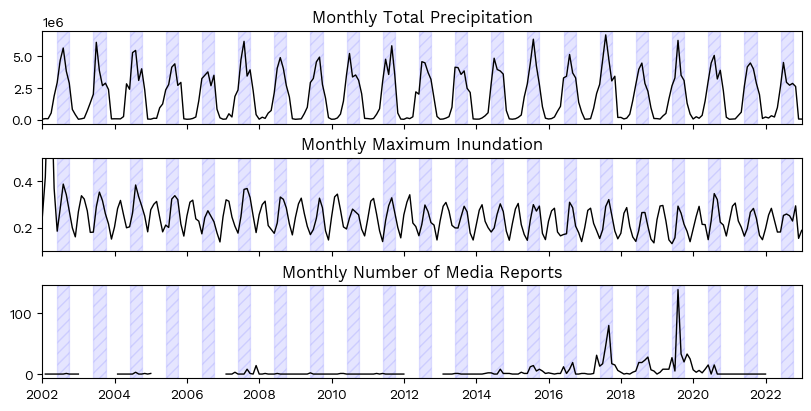

In [202]:
fig, axes = plt.subplots(3, 1, figsize=(8,4), sharex=True, constrained_layout=True)
names=['Monthly Total Precipitation', 'Monthly Maximum Inundation', 'Monthly Number of Media Reports']

# Precip
ax=axes[0]
ax.set_title(names[0])
ax.plot(iplot, precipMonthlyTotal, c= 'k', linewidth=1, label='Precipitation')
# ax.plot(iplot, precipMonthlyTotal3, c= 'r', linewidth=1, label='Precipitation')

# Inundation
ax=axes[1]
ax.set_title(names[1])
ax.plot(iplot, FIAMonthlyTotal, c= 'k', linewidth=1, label='Inundation')
ax.set_ylim(0.1, 0.5)

# NP
ax=axes[2]
ax.set_title(names[2])
ax.plot(nlpMonthlyCount.time, nlpMonthlyCount.sel(division='All'), c= 'k', linewidth=1, label='Media reports')
# ax.set_ylim(0.1, 0.5)

startPlot, endPlot = pd.to_datetime('2002-01-01'), pd.to_datetime('2022-12-31')
ax.set_xlim(startPlot, endPlot)


# Add monsoon fill
for ax in axes:
    for i, monsoon in enumerate(monsoons):
        ax.axvspan(monsoon[0], monsoon[1], alpha=0.1, color='blue', hatch='///', zorder=0, label='Monsoon')

plt.show()

__Take monsoon average? Or monsoon max?__

## Do field correlation
I.e. time series of NLP against spatiomteporal field of precip or inundation, monthly timesteps

__E.g.for precip, could use monthly max, or monthly sum?__

Or take the monsoon as a whole i.e. annual? But only have 6 timesteps then...

In [367]:
# Cut time series to 2015 onwards when NLP data is thought to be robust
startTime=pd.to_datetime('2015-01-01')
endTime=pd.to_datetime('2020-09-01')
nlpMonthlyCount = nlpxr.resample(time='1M', skipna=True).sum(dim='time')
nlpMonthly=nlpMonthlyCount.sel(time=slice(startTime, endTime))

In [368]:
precipMonthlySum = precip.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlySum = precipMonthlySum[precipMonthlySum.time.isin(nlpMonthly.time)]
precipMonthlyMax = precipMonthlyMax[precipMonthlyMax.time.isin(nlpMonthly.time)]

In [369]:
fieldCorrelPrecipSum = xr.corr(nlpMonthly, precipMonthlySum, dim="time")

In [370]:
print([div for div in divs])
print([np.nanmean(fieldCorrelPrecipSum.sel(division=div)) for div in divs])

['All', 'Barisal', 'Chittagong', 'Dhaka', 'Khulna', 'Rajshahi', 'Rangpur', 'Sylhet']
[0.4859320524812556, 0.41917118791724894, 0.4979272825201254, 0.4536859590377702, 0.3329964396934817, 0.4497272993125637, 0.4407490575656777, 0.44003495463881]


__Thoughts!:__
* might need to normalize the NLP data as well (even though mean is probably zero)
* and additionally might need to remove linear trend

### Plot the field correlaiton, for precip

In [371]:
# Function to get the extend argument
def getExtend(amin, amax, vmin, vmax):
    if amin<vmin and amax<=vmax:
        extend='min'
    elif amax>vmax and amin>=vmin:
        extend='max'
    elif amin<vmin and amax>vmax:
        extend='both'
    else:
        extend='neither'
    return extend

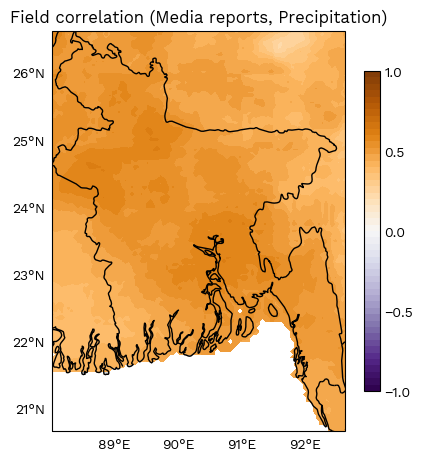

In [372]:
# Define data and arguments for plotting
plotData=fieldCorrelPrecipSum.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='Field correlation (Media reports, Precipitation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

### We can plot this separately for the media reports in each division

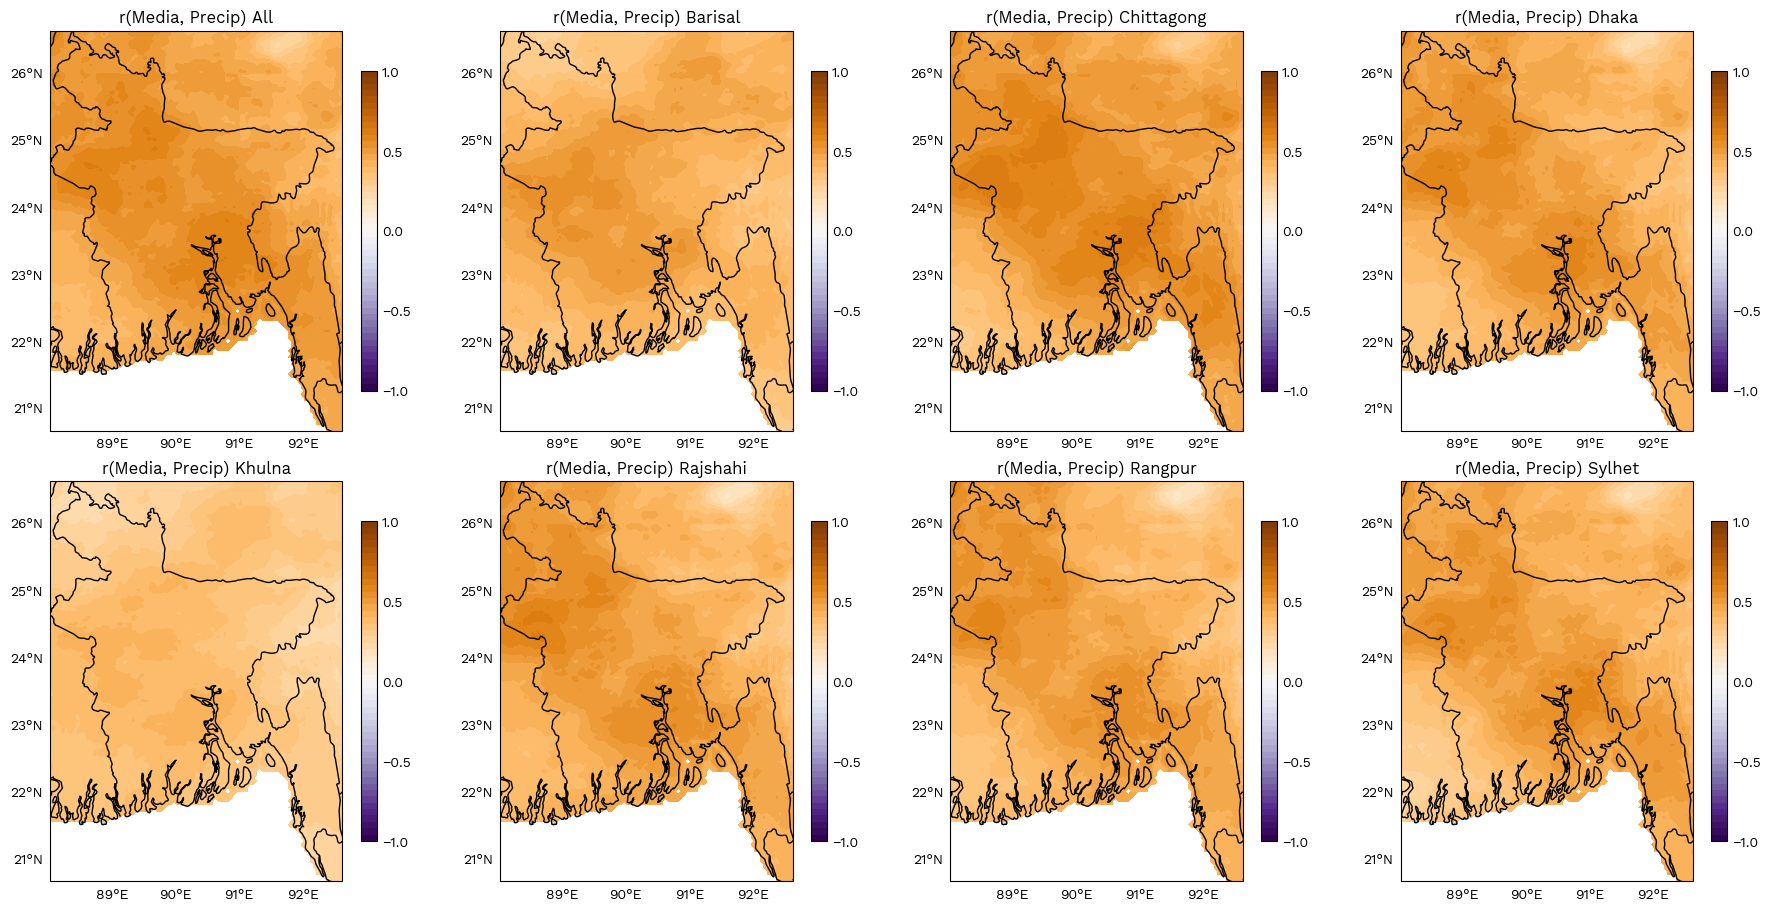

In [373]:
# Define data and arguments for plotting
plotDataAll=fieldCorrelPrecipSum#.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='r(Media, Precip)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=len(divs)
ncolsToPlot=4
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):
    plotData=plotDataAll.sel(division=divs[i])
    ax.set_title('{0} {1}'.format(titleName, divs[i]))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

### Normalize the NLP data

In [374]:
nlpMonthlyAnom = (nlpMonthly - nlpMonthly.mean(axis=0)) / nlpMonthly.std(axis=0)

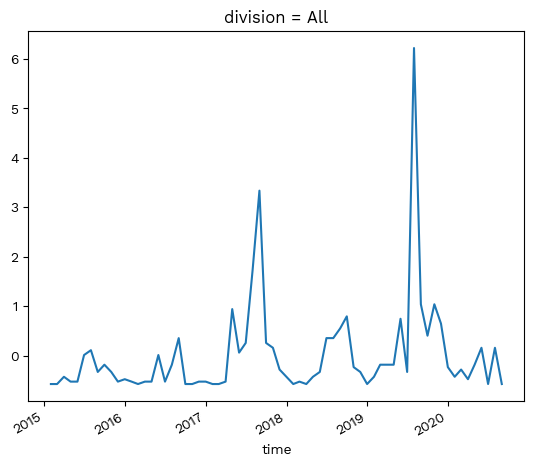

In [375]:
nlpMonthlyAnom.sel(division='All').plot()

### Detrend the NLP data

In [376]:
nlpMonthlyAnomDetrended=sp.signal.detrend(nlpMonthlyAnom, type='linear')

In [377]:
# Make back into an xarray
# Convert to xarray data array
nlpMonthlyAnomDetrended = xr.DataArray(
    nlpMonthlyAnomDetrended,
    coords={'time': nlpMonthlyAnom.time, 'division': nlpMonthlyAnom.division},
    dims=['time', 'division']
)

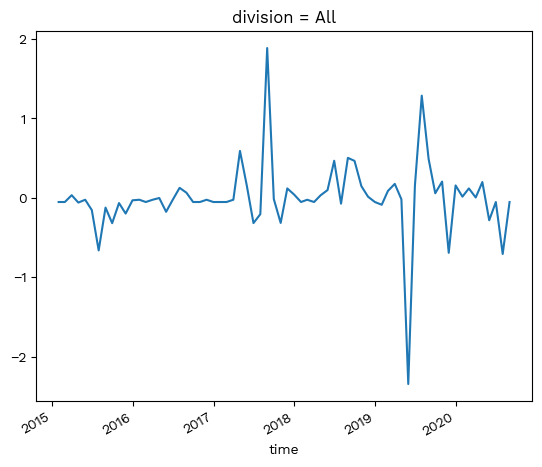

In [378]:
nlpMonthlyAnomDetrended.sel(division='All').plot()

## Repeat field correlation with precip using detrended data

In [379]:
precipMonthlySum = precip.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlySum = precipMonthlySum[precipMonthlySum.time.isin(nlpMonthlyAnomDetrended.time)]
precipMonthlyMax = precipMonthlyMax[precipMonthlyMax.time.isin(nlpMonthlyAnomDetrended.time)]

In [380]:
fieldCorrelPrecipSum = xr.corr(nlpMonthlyAnomDetrended, precipMonthlySum, dim="time")

In [381]:
print([div for div in divs])
print([np.nanmean(fieldCorrelPrecipSum.sel(division=div)) for div in divs])

['All', 'Barisal', 'Chittagong', 'Dhaka', 'Khulna', 'Rajshahi', 'Rangpur', 'Sylhet']
[0.05665643068924587, -0.0585756910094149, 0.14240428505861494, 0.033981083973883656, -0.13402621271154952, 0.06501260978140475, 0.05266989817494054, 0.0617246013319476]


In [382]:
fieldCorrelPrecipMax = xr.corr(nlpMonthlyAnomDetrended, precipMonthlyMax, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


__Thoughts!:__
* might need to normalize the NLP data as well (even though mean is probably zero)
* and additionally might need to remove linear trend

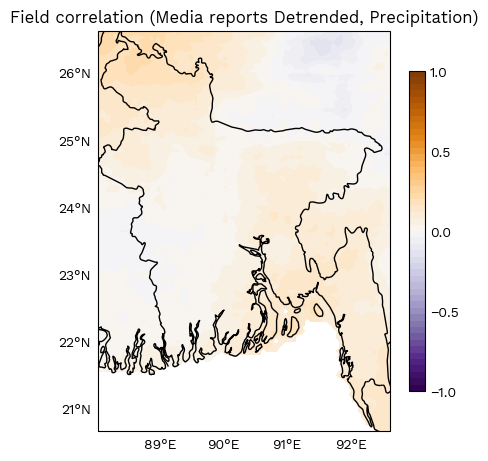

In [383]:
# Define data and arguments for plotting
plotData=fieldCorrelPrecipSum.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='Field correlation (Media reports Detrended, Precipitation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

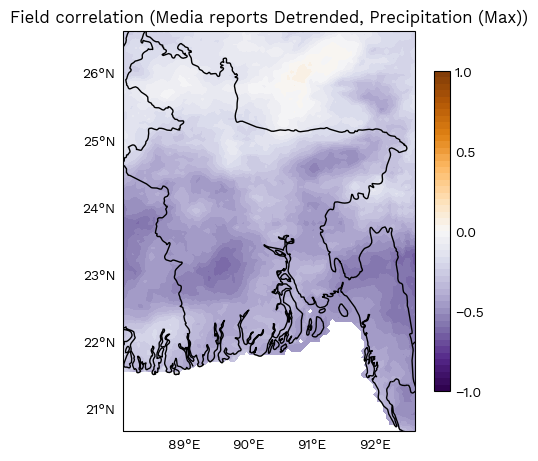

In [384]:
# Define data and arguments for plotting
plotData=fieldCorrelPrecipMax.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='Field correlation (Media reports Detrended, Precipitation (Max))'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

## Repeat for field correlation with inundation

In [385]:
FIAMonthlyMaxCoarse = FIAMonthlyMaxCoarse[FIAMonthlyMaxCoarse.time.isin(nlpMonthly.time)]
fieldCorrelFIA = xr.corr(nlpMonthly, FIAMonthlyMaxCoarse, dim="time")
fieldCorrelFIADetrended = xr.corr(nlpMonthlyAnomDetrended, FIAMonthlyMaxCoarse, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [386]:
print([div for div in divs])
print([np.nanmean(fieldCorrelFIA.sel(division=div)) for div in divs])

['All', 'Barisal', 'Chittagong', 'Dhaka', 'Khulna', 'Rajshahi', 'Rangpur', 'Sylhet']
[0.07560448534976462, -0.017649052412482602, 0.07066974186049611, 0.09513623794619369, -0.04012339750836557, 0.12300727914943138, 0.14310131132020867, 0.08406854243026333]


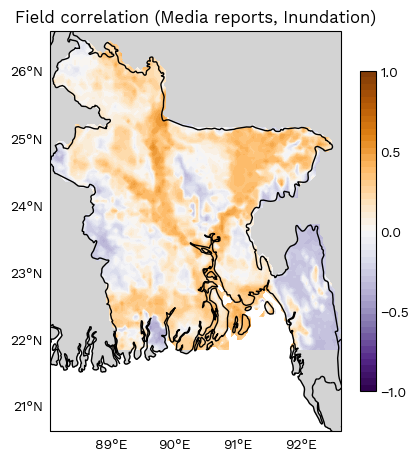

In [387]:
# Define data and arguments for plotting
plotData=fieldCorrelFIA.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=FIAMonthlyMaxCoarse
titleName='Field correlation (Media reports, Inundation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

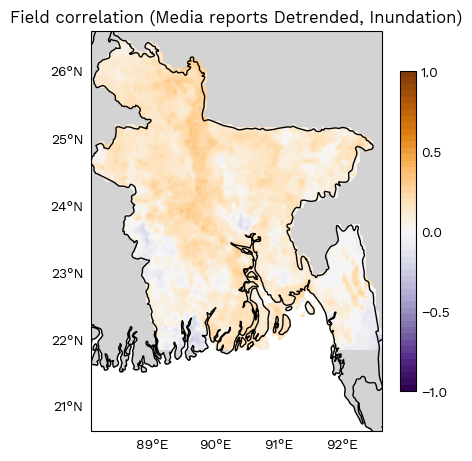

In [388]:
# Define data and arguments for plotting
plotData=fieldCorrelFIADetrended.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=FIAMonthlyMaxCoarse
titleName='Field correlation (Media reports Detrended, Inundation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

__Initial reaction!__

So, even after detrending, we see higher positive correlations remain between inundation and the media reports, than we do between precipitation and the media reports...

Is inundation more correlated with human impacts than precipitation...?

Would need to do a significance field on this to check if signal stands above noise..

...but how it follows the main rivers, suggests there is indeed a signal there...!